In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
%matplotlib inline
np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white',context='notebook',palette='deep')


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



Using TensorFlow backend.


/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/sample_submission.csv


## **data preparation**

In [2]:
train=pd.read_csv("../input/digit-recognizer/train.csv")
test=pd.read_csv("../input/digit-recognizer/test.csv")

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

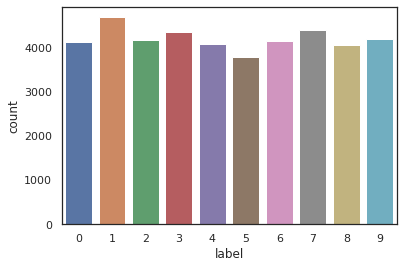

In [4]:
y_train=train['label']

X_train=train.drop(labels=['label'],axis=1)

del train

g=sns.countplot(y_train)
y_train.value_counts()

## **check for null or missing values**

In [5]:
X_train.isna().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [6]:
test.isna().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

## **Normalization**

CNN converges faster on [0..1] data than on [0..255]

In [7]:
X_train=X_train/255.0
test=test/255.0

## **Reshape**

In [8]:
#3dimension image --> (height=28px,width=28px,canal=1)
X_train=X_train.values.reshape(-1,28,28,1)
test=test.values.reshape(-1,28,28,1)

## **label encoding**

In [9]:
# encode labels to one hot vectors (ex: 2 -->[0,0,1,0,0,0,0,0,0,0])

y_train=to_categorical(y_train,num_classes=10)

## **Split training an validation set**

In [10]:
# set the random seed
random_seed=2

In [11]:
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=random_seed)

## **Visualization**
    Some Examples

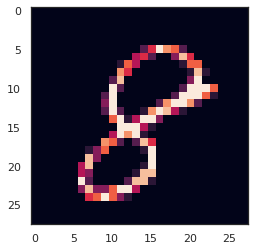

In [12]:
plt.imshow(X_train[0][:,:,0])

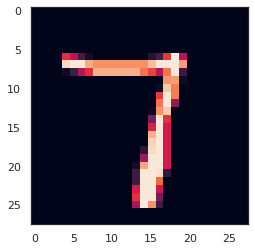

In [13]:
plt.imshow(X_train[1][:,:,0])

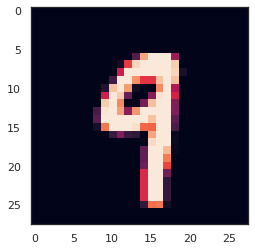

In [14]:
plt.imshow(X_train[2][:,:,0])

# **CNN **

In [15]:
# set the cnn model
# my CNN architecture is --> [[Conv2D->relu]*2 -> MaxPool2D --> Dropout]*2 --> Flatten --> Dense --> Dropout -->Output

model=Sequential()

model.add(Conv2D(filters=32,kernel_size=(5,5),padding='Same',activation='relu',input_shape=(28,28,1)))
model.add(Conv2D(filters=32,kernel_size=(5,5),padding='Same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64,kernel_size=(3,3),padding='Same',activation='relu'))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding='Same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
# ANN
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10,activation='softmax'))



## **Set the optimizer and annealer**

In [16]:
#define the optimizer
optimizer=RMSprop(lr=0.001,rho=0.9,epsilon=1e-08,decay=0.0)

In [17]:
#compile the model
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [18]:
#set learning rate annealer
learning_rate_reduction=ReduceLROnPlateau(monitor='val_acc',
                                         patience=3,
                                         verbose=1,
                                         factor=0.5,
                                         min_lr=0.00001)

### **Data Augmentation**

In [19]:
datagen=ImageDataGenerator(featurewise_center=False,
                          samplewise_center=False,
                          featurewise_std_normalization=False,
                          samplewise_std_normalization=False,
                          zca_whitening=False,
                          rotation_range=10,
                          zoom_range=0.1,
                          width_shift_range=0.1,
                          height_shift_range=0.1,
                          horizontal_flip=False,
                          vertical_flip=False)
datagen.fit(X_train)

# don't applied vertical nor horizontal flip as it will lead to misclassify numbers 6 and 9

In [20]:
#fit the model

history=model.fit_generator(datagen.flow(X_train,y_train,batch_size=32),
                            epochs=30,
                            validation_data=(X_val,y_val),
                            verbose=2,
                            steps_per_epoch=X_train.shape[0]//32,
                            callbacks=[learning_rate_reduction])
                            

Epoch 1/30
 - 21s - loss: 0.3276 - accuracy: 0.8975 - val_loss: 0.0702 - val_accuracy: 0.9814
Epoch 2/30


/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 17s - loss: 0.1210 - accuracy: 0.9649 - val_loss: 0.0399 - val_accuracy: 0.9879
Epoch 3/30
 - 16s - loss: 0.1028 - accuracy: 0.9707 - val_loss: 0.0349 - val_accuracy: 0.9907
Epoch 4/30
 - 18s - loss: 0.0953 - accuracy: 0.9730 - val_loss: 0.0337 - val_accuracy: 0.9879
Epoch 5/30
 - 16s - loss: 0.0976 - accuracy: 0.9742 - val_loss: 0.0418 - val_accuracy: 0.9893
Epoch 6/30
 - 17s - loss: 0.0969 - accuracy: 0.9750 - val_loss: 0.0368 - val_accuracy: 0.9895
Epoch 7/30
 - 17s - loss: 0.1034 - accuracy: 0.9744 - val_loss: 0.0480 - val_accuracy: 0.9893
Epoch 8/30
 - 17s - loss: 0.1048 - accuracy: 0.9726 - val_loss: 0.0454 - val_accuracy: 0.9883
Epoch 9/30
 - 16s - loss: 0.1130 - accuracy: 0.9719 - val_loss: 0.0939 - val_accuracy: 0.9781
Epoch 10/30
 - 16s - loss: 0.1181 - accuracy: 0.9714 - val_loss: 0.0625 - val_accuracy: 0.9888
Epoch 11/30
 - 17s - loss: 0.1145 - accuracy: 0.9721 - val_loss: 0.0864 - val_accuracy: 0.9840
Epoch 12/30
 - 16s - loss: 0.1248 - accuracy: 0.9705 - val_loss: 0.06

## **Evaluate the model**

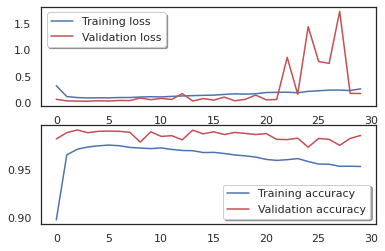

In [24]:
fig,ax=plt.subplots(2,1)
ax[0].plot(history.history['loss'],color='b',label="Training loss")
ax[0].plot(history.history['val_loss'],color='r',label="Validation loss")
legend=ax[0].legend(loc='best',shadow=True)

ax[1].plot(history.history['accuracy'],color='b',label="Training accuracy")
ax[1].plot(history.history['val_accuracy'],color='r',label="Validation accuracy")
legend=ax[1].legend(loc='best',shadow=True)

In [26]:
y_pred=model.predict(X_val)
y_pred_classes=np.argmax(y_pred,axis=1)
y_true=np.argmax(y_val,axis=1)
con_mat=confusion_matrix(y_true,y_pred_classes)
pd.DataFrame(con_mat,columns=np.arange(0,10,1),index=np.arange(0,10,1))

,0,1,2,3,4,5,6,7,8,9
0,400,0,2,1,0,1,5,0,1,1
1,0,478,1,1,2,1,0,2,0,0
2,0,0,400,1,0,0,0,1,1,0
3,0,0,1,415,0,1,0,0,1,0
4,0,1,1,0,455,0,1,0,0,3
5,0,0,0,2,0,366,2,0,1,1
6,2,1,0,0,1,0,409,0,0,0
7,0,1,1,0,0,0,0,444,0,0
8,1,0,1,1,3,0,1,0,374,1
9,1,1,0,0,9,1,0,1,0,396


## **Final prediction on test data**

In [27]:
results=model.predict(test)
results=np.argmax(results,axis=1)
results=pd.Series(results,name='Label')

## **Submission**

In [30]:
submission=pd.concat([pd.Series(range(1,28001),name='ImageId'),results],axis=1)
submission.to_csv("cnn_mnist_predict.csv",index=False)

In [32]:
pd.read_csv("cnn_mnist_predict.csv").head(10)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
